## Motion Detection

### Creating test images

In [1]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
import time
import pandoc

### Helper functions

described later ...

In [2]:
def tileImg(nrow, ncol, width, height):
    n_row_step = height // nrow
    n_col_step = width // ncol
    tiles = []

    for m in range(nrow):
        row_start = m * n_row_step
        row_end = row_start + n_row_step - 1
            
        for k in range(ncol):
            col_start = k * n_col_step
            col_end = col_start + n_col_step - 1
            tiles.append([row_start, row_end, col_start, col_end])
    return tiles

def imgDiffGtThr(img_th, tiles, percent=0.02):
    # detecting interesting parts; those subimages of img_th where
    # nr of pixels != 0 are above a threshold (given in percent)
    # return tiles
    tiles_exceeding_percent = []

    for row_start, row_end, col_start, col_end in tiles:
        npixels = (row_end - row_start + 1) * (col_end - col_start + 1)
        pc = cv2.countNonZero(img_th[row_start:row_end, col_start:col_end]) / npixels
        if pc > percent:
            tiles_exceeding_percent.append([(col_start, row_start), (col_end, row_end)])
    return tiles_exceeding_percent

#### loading images: identical scene, identical camera position ... but: images have been created differently

The same scene has been captured with the HQ-camera module with different methods:

1) image has been captured directly into a file as a compressed image (jpeg) 

2) image has been captured as array (ndarray object) and save to file as jpeg (using OpenCV)

3) image has been captured as array (ndarray object) and saved to file (no compression)

Images are then retrieved from file and stored in ndarray objects

It is shown that the shapes of all three images are identical.

##### note:

OpenCV reads color channel in order *{blue, green, red}* ; 
reordering may be necessary to display image with imshow of matplotlib which expects different color order: *{red, green, blue}*)

In [3]:
# 1) image has been captured directly into a file as a compressed image (jpeg)
imgFile1 = "img/img_indentical/img_jpg_ex1.jpg"

# 2) image has been captured as array (ndarray object) and save to file as jpeg (using OpenCV)
imgFile2 = "img/img_indentical/img_numpy_ex1.jpg"

# 3) image has been captured as array (ndarray object) and saved to file (no compression)
imgFile3 = "img/img_indentical/img_numpy_ex1.npy"

# reindexing images read from opencv method : wanted color ordering: RGB
img1 = cv2.imread(imgFile1)[:,:,[2, 1, 0]]
img2 = cv2.imread(imgFile2)[:,:,[2, 1, 0]]

# no bgr to RGB ordering required -> image has been captured as array in RGB order and saved accordingly
img3 = np.load(imgFile3)

# showing that images have identical shapes (height, width, nr of colors-channels)
height1, width1, channels1 = img1.shape
height2, width2, channels2 = img2.shape
height3, width3, channels3 = img3.shape
print(f"height1: {height1}; width1: {width1}; channels1: {channels1}")
print(f"height2: {height2}; width2: {width2}; channels2: {channels2}")
print(f"height3: {height3}; width3: {width3}; channels3: {channels3}")

height1: 1080; width1: 1920; channels1: 3
height2: 1080; width2: 1920; channels2: 3
height3: 1080; width3: 1920; channels3: 3


### Displaying images

Since we have 3 images taken from the same scene with unchanged camera position these images should look identical. Later it is demonstrated that each image is slightly different depending on how it has been captured and stored to a file.

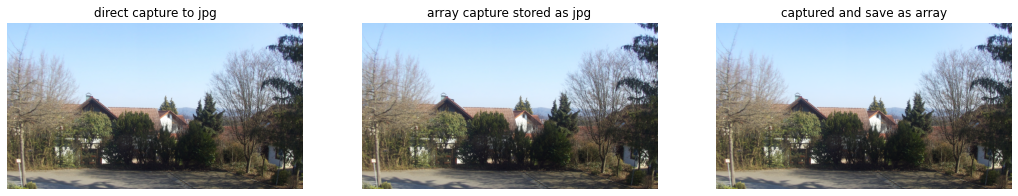

In [4]:
fig1 = plt.figure(1, figsize=[18, 6])
ax_f1 = fig1.add_subplot(1, 3, 1)
ax_f1.imshow(img1)
ax_f1.set_title('direct capture to jpg')
ax_f1.axis('off')

ax_f2 = fig1.add_subplot(1, 3, 2)
ax_f2.imshow(img2)
ax_f2.set_title('array capture stored as jpg')
ax_f2.axis('off')

ax_f3 = fig1.add_subplot(1, 3, 3)
ax_f3.imshow(img3)
ax_f3.set_title('captured and save as array')
ax_f3.axis('off');

# saving to file
fig1_file_name = "img/img_indentical/fig1.jpg"
fig1.savefig(fig1_file_name, dpi=150)

### Why images are still different 

An image captured to a ndarray and saved to file using numpy.save() method is a "lossless" representation of the captured image since it has not been compressed before saving it. On a per pixel basis such image must be different to images which  have been captured and compressed before storing them.

But even for two images which have been captured in a compressed format (see method 2 and 3) small differences should be expected. (method 2 used OpenCV to compress to jpeg while method 3 used the built-in codec of the camera)

And if we had captured two consecutive images in a lossless format (numpy) these images would be slightly different due to 
the additive noise added by the camera's sensor during capturing these images.

When deciding whether images are identical (almost identical) or significantly different, the effect of noise in images must be taken into account.

### How to compare images which are almost identical but noisy 

step 1)

from the original images img1, img2, img3 obtain blurred versions of images. Here we apply gaussian blurring. Note: Convert to gray scale images before blurring.

step 2)

take absolute difference images. Since we have 3 images there 3 image pairs to consider when taken absolute differences:

img1_2 := absdiff of images (img1_blur, img2_blur)

img1_3 := absdiff of images (img1_blur, img3_blur)

img2_3 := absdiff of images (img2_blur, img2_blur

step 3)

apply binary thresholding to absdiff images img1_2, img1_3, img2_3; set every pixel to 0 if absdiff is below threshold. Otherwise set to maximum (255). As a result we get thresholded images:

img1_2_th, img1_3_th, img2_3_th

In [5]:
threshold = 20

# blurring after converting to gray scale images
img1_blur = cv2.GaussianBlur(src=cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), ksize=(5, 5), sigmaX=0)
img2_blur = cv2.GaussianBlur(src=cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY), ksize=(5, 5), sigmaX=0)
img3_blur = cv2.GaussianBlur(src=cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY), ksize=(5, 5), sigmaX=0)

# absdiff of gray scale images
img1_2 = cv2.absdiff(img1_blur, img2_blur)
img1_3 = cv2.absdiff(img1_blur, img3_blur)
img2_3 = cv2.absdiff(img2_blur, img3_blur)

# thresholding
img1_2_th = cv2.threshold(src=img1_2, thresh=threshold, maxval=255, type=cv2.THRESH_BINARY)[1]
img1_3_th = cv2.threshold(src=img1_3, thresh=threshold, maxval=255, type=cv2.THRESH_BINARY)[1]
img2_3_th = cv2.threshold(src=img2_3, thresh=threshold, maxval=255, type=cv2.THRESH_BINARY)[1]

### Show thresholded images

Since original images have been almost identical, blurred and then thresholded images are mostly black (0). Only a few speckles of white (255) occur.

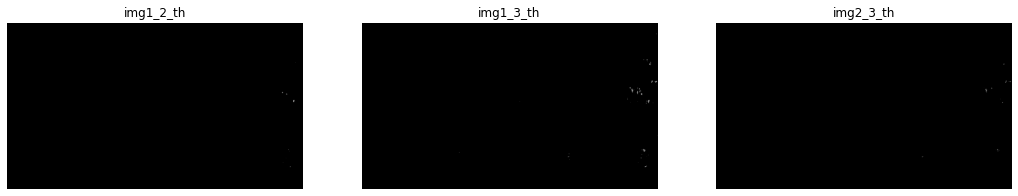

In [6]:
fig2 = plt.figure(2, figsize=[18, 6])
ax_f2_1 = fig2.add_subplot(1, 3, 1)
ax_f2_1.imshow(img1_2_th, cmap='gray')
ax_f2_1.set_title('img1_2_th')
ax_f2_1.axis('off')

ax_f2_2 = fig2.add_subplot(1, 3, 2)
ax_f2_2.imshow(img1_3_th, cmap='gray')
ax_f2_2.set_title('img1_3_th')
ax_f2_2.axis('off')

ax_f2_3 = fig2.add_subplot(1, 3, 3)
ax_f2_3.imshow(img2_3_th, cmap='gray')
ax_f2_3.set_title('img2_3_th')
ax_f2_3.axis('off');

# saving to file
fig2_file_name = "img/img_indentical/fig2.jpg"
fig2.savefig(fig2_file_name, dpi=150)

1) counting the number of non-zero pixels for each thresholded image

2) taking the ratio of non-zero pixels to the total number of pixels of the images

3) the ratio (nr of non-zero pixels/total nr of pixels) indicates a low percentage of pixels is different from 0. This fact could be used as a coarse measure of similarity of images

In [7]:
count_non_zero_1_2 = np.sum(img1_2_th == 255)
count_non_zero_1_3 = np.sum(img1_3_th == 255)
count_non_zero_2_3 = np.sum(img2_3_th == 255)
ratio_1_2 = 100 * count_non_zero_1_2 / img1_2_th.size
ratio_1_3 = 100 * count_non_zero_1_3 / img1_3_th.size
ratio_2_3 = 100 * count_non_zero_2_3 / img2_3_th.size

print(f"count_non_zero_1_2: {count_non_zero_1_2} ; ratio: {ratio_1_2:8.4f} %")
print(f"count_non_zero_1_3: {count_non_zero_1_3} ; ratio: {ratio_1_3:8.4f} %")
print(f"count_non_zero_2_3: {count_non_zero_1_2} ; ratio: {ratio_2_3:8.4f} %")

count_non_zero_1_2: 127 ; ratio:   0.0061 %
count_non_zero_1_3: 819 ; ratio:   0.0395 %
count_non_zero_2_3: 127 ; ratio:   0.0094 %


### Another Example

The first image is the original image. The second image has been obtained by modifying the original image.

-> A square blue patch has been added to the image

Obtain images img4 and img5 from file, and change color order from BGR to RGB by reindexing. 

Make a compy of img4 -> img4_with_tiles ; will be used later to superimpose rectangle where image is different from the original image img4

To compare images img4, img5 convert to gray scale images first, then apply gaussian blurring, create an image of absolute differences, apply thresholding.

img4_5_th is the image after thresholding has been applied.

In [8]:
imgFile4 = "img/cistern_caffee.jpg"
imgFile5 = "img/cistern_caffee_blue_patch.jpg"

img4 = cv2.imread(imgFile4)[:,:,[2,1,0]]
img4_with_tiles = img4.copy()
img5 = cv2.imread(imgFile5)[:,:,[2,1,0]]

# blurred and converted to gray scale
img4_blur = cv2.GaussianBlur(src=cv2.cvtColor(img4, cv2.COLOR_BGR2GRAY), ksize=(5, 5), sigmaX=0)
img5_blur = cv2.GaussianBlur(src=cv2.cvtColor(img5, cv2.COLOR_BGR2GRAY), ksize=(5, 5), sigmaX=0)

# absdiff of gray scale images
img4_5 = cv2.absdiff(img4_blur, img5_blur)

# thresholding
img4_5_th = cv2.threshold(src=img4_5, thresh=threshold, maxval=255, type=cv2.THRESH_BINARY)[1]

### Create Tiles 

img4_5_th is partitioned into tile which define the boundaries of subimages

A total number of nrow * ncol tiles / subimages will be used

Iterating over each tile the count of non-zero pixels is detected. If the ratio of (count non-zero pixels/count pixels of tile) exceed a threshold, the coordinates of the tile is appended to list tiles_exceeding_percent.

Each tile where the percentage is exceed is marked by yellow rectangle in the image; this helps to see where changes between two images occurred.

#### note:

Helper function tileImg() creates a list of tiles

Helper function imgDiffGtThr() returns a list of tiles where the subimage shows significant changes.

In [9]:
# creates tiles (10 rows, 10 colums: -> 100 tiles or subimages)
width, height = img4_5_th.shape
nrow = 10
ncol = 10
tiles = tileImg(nrow, ncol, width, height)

# detect tiles where percentage of non-zero pixels exceeds threshold
tiles_exceeding_percent = imgDiffGtThr(img4_5_th, tiles, percent=0.02)
print(f"{tiles_exceeding_percent}")

[[(1552, 777), (1745, 1035)]]


### Mark parts of image

The yellow rectangle marks where the two images are different (due to the blue patch ...)

In [10]:
for upper_left, lower_right in tiles_exceeding_percent:
    # add a yellow rectangle where percentage is exceeded
    cv2.rectangle(img4_with_tiles, upper_left, lower_right, (255, 255, 0), 15)

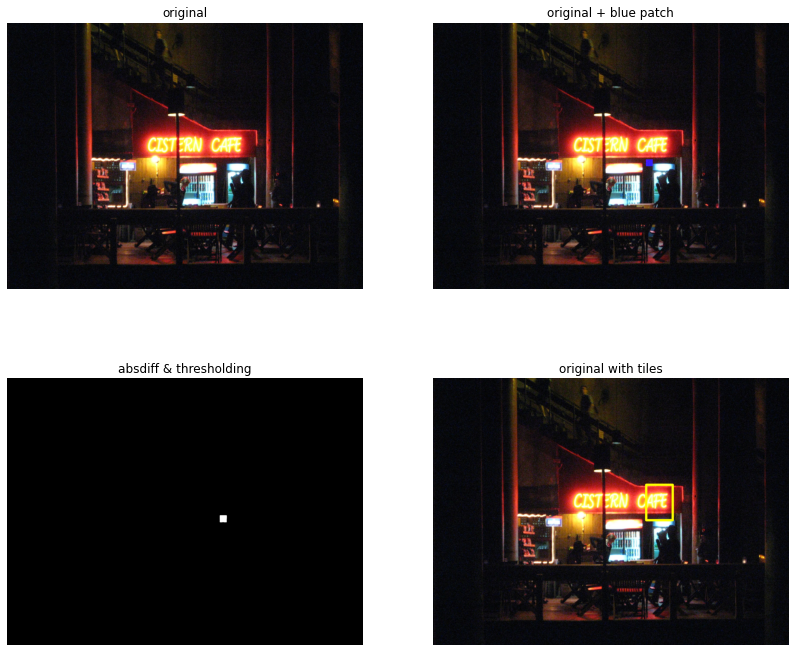

In [11]:
fig3 = plt.figure(3, figsize=[14, 12])
# original image
ax_f3_1 = fig3.add_subplot(2, 2, 1)
ax_f3_1.imshow(img4)
ax_f3_1.set_title('original')
ax_f3_1.axis('off')

# original image modified with blue patch
ax_f3_2 = fig3.add_subplot(2, 2, 2)
ax_f3_2.imshow(img5)
ax_f3_2.set_title('original + blue patch')
ax_f3_2.axis('off')

ax_f3_3 = fig3.add_subplot(2, 2, 3)
ax_f3_3.imshow(img4_5_th, cmap='gray')
ax_f3_3.set_title('absdiff & thresholding')
ax_f3_3.axis('off')

ax_f3_4 = fig3.add_subplot(2, 2, 4)
ax_f3_4.imshow(img4_with_tiles)
ax_f3_4.set_title('original with tiles')
ax_f3_4.axis('off');

# saving to file
fig3_file_name = "img/img_indentical/fig3.jpg"
fig3.savefig(fig3_file_name, dpi=150)

In [25]:
imgFile6 = "img/img_different/img_jpg_ex1_3.jpg"
imgFile7 = "img/img_different/img_jpg_ex1_4.jpg"

img6 = cv2.imread(imgFile6)[:,:,[2,1,0]]
img6_with_tiles_gauss = img6.copy()
img6_with_tiles_median = img6.copy()
img7 = cv2.imread(imgFile7)[:,:,[2,1,0]]

# blurred and converted to gray scale
img6_blur = cv2.GaussianBlur(src=cv2.cvtColor(img6, cv2.COLOR_BGR2GRAY), ksize=(5, 5), sigmaX=0)
img7_blur = cv2.GaussianBlur(src=cv2.cvtColor(img7, cv2.COLOR_BGR2GRAY), ksize=(5, 5), sigmaX=0)

img8_blur = cv2.medianBlur(src=cv2.cvtColor(img6, cv2.COLOR_BGR2GRAY), ksize=9)
img9_blur = cv2.medianBlur(src=cv2.cvtColor(img7, cv2.COLOR_BGR2GRAY), ksize=9)

# absdiff of gray scale images
img6_7 = cv2.absdiff(img6_blur, img7_blur)
img8_9 = cv2.absdiff(img8_blur, img9_blur)

# thresholding
img6_7_th = cv2.threshold(src=img6_7, thresh=30, maxval=255, type=cv2.THRESH_BINARY)[1]
img8_9_th = cv2.threshold(src=img8_9, thresh=30, maxval=255, type=cv2.THRESH_BINARY)[1]

### Create Tiles etc.

In [26]:
height, width = img6_7_th.shape
nrow = 10
ncol = 10

# the tiles
tiles = tileImg(nrow, ncol, width, height)

# detect tiles where percentage of non-zero pixels exceeds threshold
tiles_exceeding_percent_1 = imgDiffGtThr(img6_7_th, tiles, percent=0.02)
tiles_exceeding_percent_2 = imgDiffGtThr(img8_9_th, tiles, percent=0.02)
print(f"{tiles_exceeding_percent}")

[[(1728, 864), (1919, 971)]]


In [27]:
for upper_left, lower_right in tiles_exceeding_percent_1:
    # add a yellow rectangle where percentage is exceeded
    cv2.rectangle(img6_with_tiles_gauss, upper_left, lower_right, (255, 255, 0), 10)
    
for upper_left, lower_right in tiles_exceeding_percent_2:
    # add a yellow rectangle where percentage is exceeded
    cv2.rectangle(img6_with_tiles_median, upper_left, lower_right, (255, 255, 0), 10)    

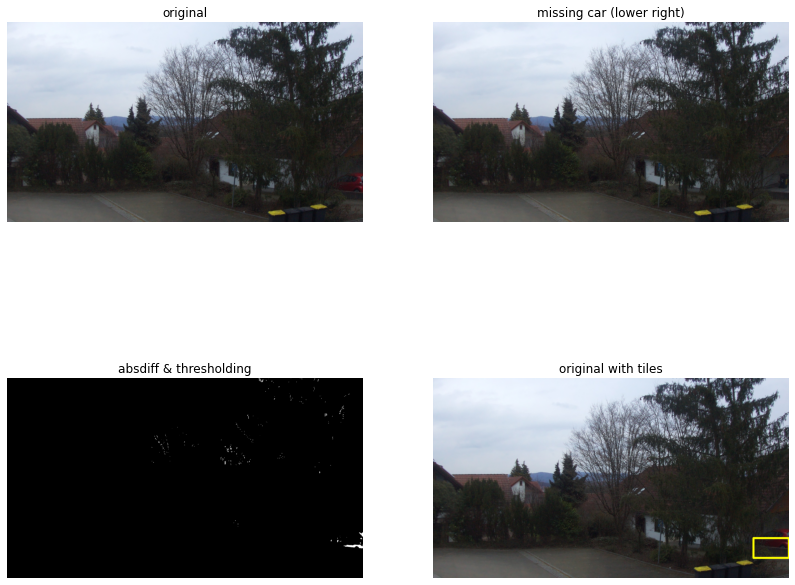

In [28]:
fig4 = plt.figure(4, figsize=[14, 12])
# original image
ax_f4_1 = fig4.add_subplot(2, 2, 1)
ax_f4_1.imshow(img6)
ax_f4_1.set_title('original')
ax_f4_1.axis('off')

# original image modified with blue patch
ax_f4_2 = fig4.add_subplot(2, 2, 2)
ax_f4_2.imshow(img7)
ax_f4_2.set_title('missing car (lower right)')
ax_f4_2.axis('off')

ax_f4_3 = fig4.add_subplot(2, 2, 3)
ax_f4_3.imshow(img6_7_th, cmap='gray')
ax_f4_3.set_title('absdiff & thresholding')
ax_f4_3.axis('off')

ax_f4_4 = fig4.add_subplot(2, 2, 4)
ax_f4_4.imshow(img6_with_tiles_gauss)
ax_f4_4.set_title('original with tiles')
ax_f4_4.axis('off');

# saving to file
fig4_file_name = "img/img_indentical/fig4.jpg"
fig4.savefig(fig4_file_name, dpi=150)

## Preprocessing of images

To detect the difference of two images it is sometimes recommend to preprocess each image first by an average filter before  taking the difference image and apply thresholds.

Here is a result with a *median* filter for *noise reduction*.

Compared to gaussian blurring it seems that noise reduction is slightly improved; but more experiments are needed...


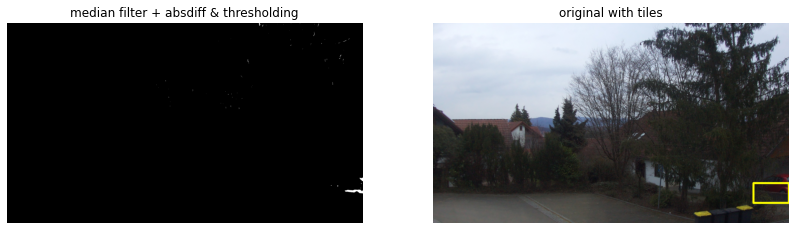

In [29]:
fig5 = plt.figure(5, figsize=[14, 12])
# original image
ax_f5_1 = fig5.add_subplot(1, 2, 1)
ax_f5_1.imshow(img8_9_th, cmap='gray')
ax_f5_1.set_title('median filter + absdiff & thresholding')
ax_f5_1.axis('off')

ax_f5_2 = fig5.add_subplot(1, 2, 2)
ax_f5_2.imshow(img6_with_tiles_median)
ax_f5_2.set_title('original with tiles')
ax_f5_2.axis('off');